In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import keras
import tensorflow as tf
import numpy as np
import re

from jiwer import wer

import matplotlib.pyplot as plt

from consonance.ml_logic.omr import build_model, ctc_decode, decode_batch_predictions, decode_labels, int_to_label, train_dataset, validation_dataset

In [4]:
prediction_model = keras.models.load_model("../data/predict_dual_1k.keras")

Number of images found:  10000
Number of labels found:  10000
Number of unique characters (label values):  85
Unique label values (characters):  ['A4_16th', 'A4_eighth', 'A4_half', 'A4_quarter', 'A4_whole', 'A5_16th', 'A5_eighth', 'A5_half', 'A5_quarter', 'A5_whole', 'B3_16th', 'B3_eighth', 'B3_half', 'B3_quarter', 'B3_whole', 'B4_16th', 'B4_eighth', 'B4_half', 'B4_quarter', 'B4_whole', 'B5_16th', 'B5_eighth', 'B5_half', 'B5_quarter', 'B5_whole', 'C4_16th', 'C4_eighth', 'C4_half', 'C4_quarter', 'C4_whole', 'C5_16th', 'C5_eighth', 'C5_half', 'C5_quarter', 'C5_whole', 'C6_16th', 'C6_eighth', 'C6_half', 'C6_quarter', 'C6_whole', 'D4_16th', 'D4_eighth', 'D4_half', 'D4_quarter', 'D4_whole', 'D5_16th', 'D5_eighth', 'D5_half', 'D5_quarter', 'D5_whole', 'D6_16th', 'D6_eighth', 'D6_half', 'D6_quarter', 'D6_whole', 'E4_16th', 'E4_eighth', 'E4_half', 'E4_quarter', 'E4_whole', 'E5_16th', 'E5_eighth', 'E5_half', 'E5_quarter', 'E5_whole', 'F4_16th', 'F4_eighth', 'F4_half', 'F4_quarter', 'F4_whole', 

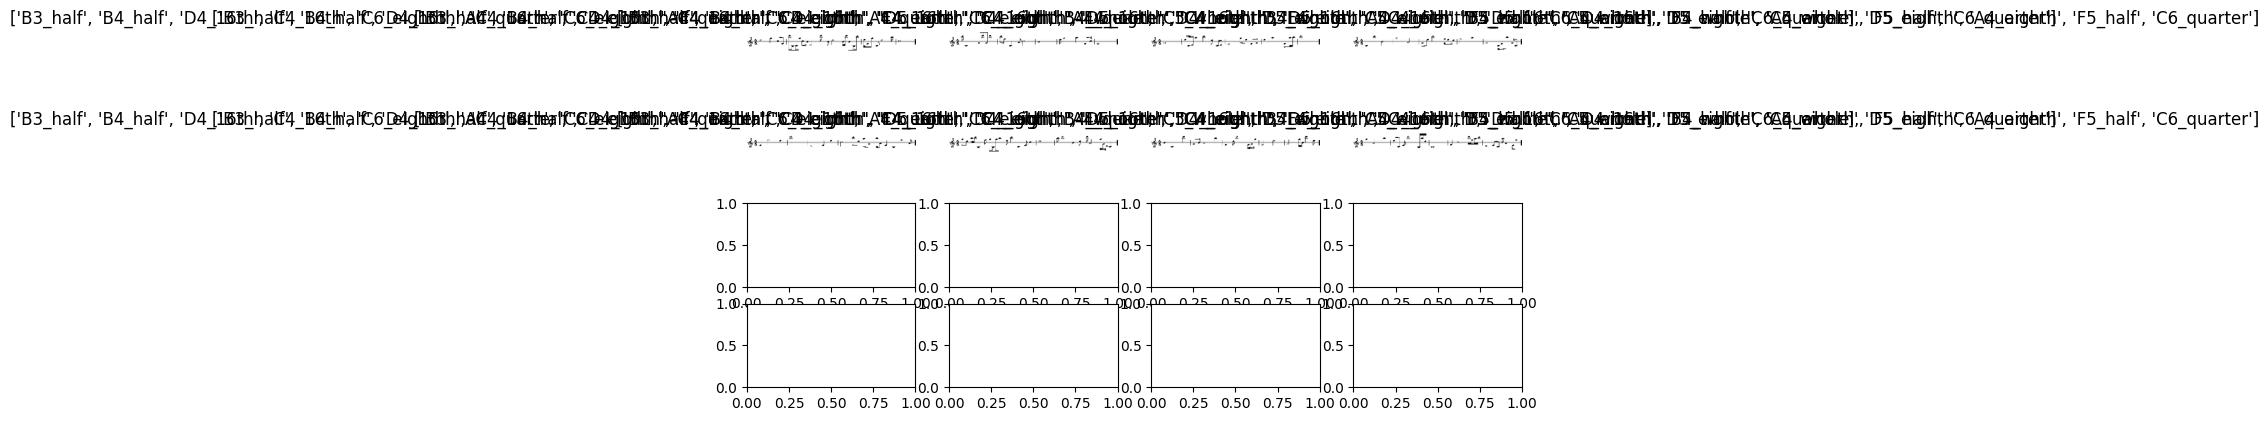

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━

In [8]:

# Convert numeric sequences back to their corresponding characters with spaces
predictions = []
targets = []
for batch in validation_dataset:
    X, y = batch['image'], batch['label']
    batch_predictions = prediction_model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)

    for label in y:
        label = ' '.join([int_to_label.get(int(lbl), '[UNK]') for lbl in label if int_to_label.get(int(lbl), '[UNK]') != '[UNK]'])
        targets.append(label)

# Function to split combined labels like "F4_halfG4_eighth" into "F4_half G4_eighth"
def split_labels(label):
    return ' '.join(re.findall(r'[A-G][b#]?\d+_\w+', label))

# Apply this function to both targets and predictions for readability
split_targets = [split_labels(label) for label in targets]
split_predictions = [split_labels(pred) for pred in predictions]

# Calculate Word Error Rate (WER)
wer_score = wer(split_targets, split_predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)

# Display some random samples of predictions and targets
for i in np.random.randint(0, len(predictions), 5):
    print(f"Target    : {split_targets[i]}")
    print(f"Prediction: {split_predictions[i]}")
    print("-" * 100)


# Metrics

In [9]:
def exact_sequence_accuracy(targets, predictions):
    correct = sum([1 for target, pred in zip(targets, predictions) if target == pred])
    total = len(targets)
    return correct / total

# Calculate exact sequence accuracy
accuracy = exact_sequence_accuracy(split_targets, split_predictions)
print(f"Exact Sequence Accuracy: {accuracy:.4f}")


Exact Sequence Accuracy: 0.0240


In [10]:
def token_level_accuracy(targets, predictions):
    correct_tokens = 0
    total_tokens = 0

    for target, pred in zip(targets, predictions):
        target_tokens = target.split()
        pred_tokens = pred.split()
        total_tokens += len(target_tokens)
        correct_tokens += sum([1 for t, p in zip(target_tokens, pred_tokens) if t == p])

    return correct_tokens / total_tokens

# Calculate token-level accuracy
accuracy = token_level_accuracy(split_targets, split_predictions)
print(f"Token-Level Accuracy: {accuracy:.4f}")


Token-Level Accuracy: 0.8308


In [11]:
def character_level_accuracy(targets, predictions):
    correct_chars = 0
    total_chars = 0

    for target, pred in zip(targets, predictions):
        total_chars += len(target)
        correct_chars += sum([1 for t, p in zip(target, pred) if t == p])

    return correct_chars / total_chars

# Calculate character-level accuracy
accuracy = character_level_accuracy(split_targets, split_predictions)
print(f"Character-Level Accuracy: {accuracy:.4f}")


Character-Level Accuracy: 0.5761


In [12]:
from jiwer import wer

# Calculate WER
wer_score = wer(split_targets, split_predictions)
print(f"Word Error Rate: {wer_score:.4f}")


Word Error Rate: 0.1211


In [13]:
def split_pitch_and_duration(token):
    """Splits a token into its pitch and duration components."""
    pitch = re.match(r'[A-G][b#]?\d+', token).group(0)
    duration = re.search(r'_(\w+)', token).group(1)
    return pitch, duration

def pitch_and_duration_accuracy(targets, predictions):
    """Calculates pitch and duration accuracy separately."""
    correct_pitches = 0
    correct_durations = 0
    total_tokens = 0

    for target, pred in zip(targets, predictions):
        target_tokens = target.split()
        pred_tokens = pred.split()
        total_tokens += len(target_tokens)

        for t_token, p_token in zip(target_tokens, pred_tokens):
            t_pitch, t_duration = split_pitch_and_duration(t_token)
            p_pitch, p_duration = split_pitch_and_duration(p_token)

            if t_pitch == p_pitch:
                correct_pitches += 1
            if t_duration == p_duration:
                correct_durations += 1

    pitch_accuracy = correct_pitches / total_tokens
    duration_accuracy = correct_durations / total_tokens

    return pitch_accuracy, duration_accuracy

# Calculate accuracy for pitch and duration separately
pitch_accuracy, duration_accuracy = pitch_and_duration_accuracy(split_targets, split_predictions)
print(f"Pitch Accuracy: {pitch_accuracy:.4f}")
print(f"Duration Accuracy: {duration_accuracy:.4f}")


Pitch Accuracy: 0.8391
Duration Accuracy: 0.8967


# New Test Predictions

In [27]:
import pandas as pd
from pathlib import Path

# Paths to test data
test_folder = Path('/Users/ninjamac/code/DataSets/test/images_cropped')
test_label_file = '/Users/ninjamac/code/DataSets/test/music/labels.csv'

# Load the CSV file with labels
test_df = pd.read_csv(test_label_file)

# Extract filenames and labels
test_images = [str(test_folder / filename) for filename in test_df['filename'].tolist()]
test_labels = [eval(label) for label in test_df['labels'].tolist()]


In [28]:
combined_dict = {
    'B3_whole': 0, 'C4_whole': 1, 'D4_whole': 2, 'E4_whole': 3, 'F4_whole': 4, 'G4_whole': 5, 'A4_whole': 6, 'B4_whole': 7, 'C5_whole': 8,
    'D5_whole': 9, 'E5_whole': 10, 'F5_whole': 11, 'G5_whole': 12, 'A5_whole': 13, 'B5_whole': 14, 'C6_whole': 15, 'D6_whole': 16,

    'B3_half': 17, 'C4_half': 18, 'D4_half': 19, 'E4_half':20, 'F4_half': 21, 'G4_half': 22, 'A4_half': 23, 'B4_half': 24, 'C5_half': 25,
    'D5_half': 26, 'E5_half': 27, 'F5_half': 28, 'G5_half': 29, 'A5_half': 30, 'B5_half': 31, 'C6_half': 32, 'D6_half': 33,

    'B3_quarter': 34, 'C4_quarter': 35, 'D4_quarter': 36, 'E4_quarter': 37, 'F4_quarter': 38, 'G4_quarter': 39, 'A4_quarter': 40, 'B4_quarter': 41, 'C5_quarter': 42,
    'D5_quarter': 43, 'E5_quarter': 44, 'F5_quarter': 45, 'G5_quarter': 46, 'A5_quarter': 47, 'B5_quarter': 48, 'C6_quarter': 49, 'D6_quarter': 50,

    'B3_eighth': 51, 'C4_eighth': 52, 'D4_eighth': 53, 'E4_eighth': 54, 'F4_eighth': 55, 'G4_eighth': 56, 'A4_eighth': 57, 'B4_eighth': 58, 'C5_eighth': 59,
    'D5_eighth': 60, 'E5_eighth': 61, 'F5_eighth': 62, 'G5_eighth': 63, 'A5_eighth': 64, 'B5_eighth': 65, 'C6_eighth': 66, 'D6_eighth': 67,

    'B3_16th': 68, 'C4_16th': 69, 'D4_16th': 70, 'E4_16th': 71, 'F4_16th': 72, 'G4_16th': 73, 'A4_16th': 74, 'B4_16th': 75, 'C5_16th': 76,
    'D5_16th': 77, 'E5_16th': 78, 'F5_16th': 79, 'G5_16th': 80, 'A5_16th': 81, 'B5_16th': 82, 'C6_16th': 83, 'D6_16th': 84
}

# Batch size for training and validation
batch_size = 16

# Desired image dimensions
img_width = 350
img_height = 50

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in test_labels])


In [29]:
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from keras import ops

# Convert labels to integer sequences
test_labels_int = [[combined_dict[label] for label in label_list] for label_list in test_labels]

# Pad the sequences to the same length
max_label_length = max(len(label) for label in test_labels_int)
test_labels_padded = pad_sequences(test_labels_int, maxlen=max_label_length, padding='post')

# Encode images for prediction
def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = ops.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = ops.transpose(img, axes=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = tf.convert_to_tensor(label, dtype=tf.int32)
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

# Create a Dataset object for the test set
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels_padded))
test_dataset = (
    test_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)


In [30]:
# Make predictions on the test set
test_predictions = []
test_targets = []
for batch in test_dataset:
    X, y = batch['image'], batch['label']
    batch_predictions = prediction_model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    test_predictions.extend(batch_predictions)

    for label in y:
        label = ' '.join([int_to_label.get(int(lbl), '[UNK]') for lbl in label if int_to_label.get(int(lbl), '[UNK]') != '[UNK]'])
        test_targets.append(label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━

2024-08-27 11:14:51.703605: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [31]:
# Apply the split_labels function to test predictions and targets
split_test_targets = [split_labels(label) for label in test_targets]
split_test_predictions = [split_labels(pred) for pred in test_predictions]

# Calculate Word Error Rate (WER) for the test set
test_wer_score = wer(split_test_targets, split_test_predictions)
print("-" * 100)
print(f"Test Set Word Error Rate: {test_wer_score:.4f}")
print("-" * 100)

# Calculate Pitch and Duration Accuracy for the test set
test_pitch_accuracy, test_duration_accuracy = pitch_and_duration_accuracy(split_test_targets, split_test_predictions)
print(f"Test Set Pitch Accuracy: {test_pitch_accuracy:.4f}")
print(f"Test Set Duration Accuracy: {test_duration_accuracy:.4f}")


----------------------------------------------------------------------------------------------------
Test Set Word Error Rate: 0.1276
----------------------------------------------------------------------------------------------------
Test Set Pitch Accuracy: 0.8343
Test Set Duration Accuracy: 0.8963


In [33]:
for i in np.random.randint(0, len(predictions), 10):
    print(f"Target    : {split_test_targets[i]}")
    print(f"Prediction: {split_test_predictions[i]}")
    print("-" * 100)

Target    : C4_half B4_16th E5_eighth B3_16th C6_16th B4_16th C4_eighth G5_quarter E5_eighth F4_half C5_eighth B4_quarter C4_half A4_eighth E4_16th C6_16th A5_whole A4_whole B3_whole B3_whole B3_whole B3_whole B3_whole B3_whole B3_whole B3_whole B3_whole B3_whole B3_whole B3_whole B3_whole B3_whole B3_whole B3_whole B3_whole B3_whole B3_whole B3_whole B3_whole B3_whole B3_whole B3_whole
Prediction: C4_half B4_16th E5_eighth B3_16th C6_16th C4_eighth G5_quarter E5_eighth F4_half C5_eighth B4_quarter C4_half A4_eighth F4_16th C6_16th C6_whole A5_whole B3_whole B3_whole B3_whole B3_whole B3_whole B3_whole B3_whole B3_whole B3_whole B3_whole B3_whole B3_whole B3_whole B3_whole B3_whole B3_whole B3_whole B3_whole B3_whole B3_whole B3_whole B3_whole B3_whole B3_whole
----------------------------------------------------------------------------------------------------
Target    : C4_whole F4_quarter G5_quarter G4_quarter D4_quarter F4_whole G4_whole B4_eighth G4_16th C5_eighth D4_quarter F5_ei